# Notebook to plot inference results.

In [103]:
import os
import re
import json
import pandas as pd

from src import config

def load_1d_experiment(base_dir, experiment_name):
    """
    Load posterior samples for one experiment (all seeds) into a DataFrame and .

    Parameters
    ----------
    base_dir : str
        Path containing subfolders like "experiment_name, seed=0", "experiment_name, seed=1", …
    experiment_name : str
        The name of the experiment to gather.

    Returns
    -------
    Tuple[pd.DataFrame, dict]
        A tuple containing:
        - DataFrame with columns ['experiment', 'seed', 'theta', 'method', 'sample']
        - config_data: dictionary with the last config.json found in the experiment folder.
    """
    records = []
    # match folders exactly like "<experiment_name>, seed=<number>"
    pattern = re.compile(rf"^{re.escape(experiment_name)}, seed=(\d+)$")
    config_path = ""
    for folder in os.listdir(base_dir):
        m = pattern.match(folder)
        if not m:
            continue
        seed = int(m.group(1))
        json_path = os.path.join(base_dir, folder, "inferences.json")
        config_path = os.path.join(base_dir, folder, "experiment_config.json")  # updating config path so we get the last one
        if not os.path.isfile(json_path):
            continue

        with open(json_path, "r") as f:
            inf = json.load(f)

        for theta, methods in inf.items():
            for method, samples in methods.items():
                for s in samples:
                    records.append({
                        "experiment": experiment_name,
                        "seed": seed,
                        "theta": theta,
                        "method": method,
                        "sample": s
                    })
    
    with open(config_path, "r") as f:
        config_data = json.load(f)

    return pd.DataFrame.from_records(records), config_data


def load_2d_experiment(base_dir, experiment_name):
    """
    Load 2D posterior samples for one experiment (all seeds) into a DataFrame,
    storing each draw as a list of lists, plus the last experiment config.

    Returns
    -------
    df : pd.DataFrame
        Columns: ['experiment','seed','theta','method','sample_idx','sample']
        where 'sample' is always a list of lists (a matrix).
    config_data : dict
        JSON from the last experiment_config.json found.
    """
    records = []
    pattern = re.compile(rf"^{re.escape(experiment_name)}, seed=(\d+)$")
    config_path = None

    for folder in os.listdir(base_dir):
        m = pattern.match(folder)
        if not m:
            continue
        seed = int(m.group(1))
        inf_path = os.path.join(base_dir, folder, "inferences.json")
        cfg_path = os.path.join(base_dir, folder, "experiment_config.json")
        if os.path.isfile(cfg_path):
            config_path = cfg_path
        if not os.path.isfile(inf_path):
            continue

        with open(inf_path, "r") as f:
            inf = json.load(f)

        for theta_name, methods in inf.items():
            for method_name, samples in methods.items():
                # ensure we have a list to iterate
                if not isinstance(samples, list):
                    samples = [samples]

                for idx, sam in enumerate(samples):
                    # if this draw isn't already a matrix, wrap into 1×1
                    if not (isinstance(sam, list) and all(isinstance(row, list) for row in sam)):
                        sam = [[sam]]
                    records.append({
                        "experiment":  experiment_name,
                        "seed":        seed,
                        "theta":       theta_name,
                        "method":      method_name,
                        "sample_idx":  idx,
                        "sample":      sam
                    })

    # load last config, if any
    config_data = {}
    if config_path:
        with open(config_path, "r") as f:
            config_data = json.load(f)

    df = pd.DataFrame.from_records(records)
    return df, config_data


import matplotlib.pyplot as plt

def plot_boxplots_by_seed(df, theta_name):
    dfθ = df[df['theta'] == theta_name]
    seeds   = sorted(dfθ['seed'].unique())
    methods = dfθ['method'].unique()

    # Collect data in order: for each seed, for each method
    data, labels = [], []
    for seed in seeds:
        for method in methods:
            samp = dfθ[(dfθ['seed']==seed) & (dfθ['method']==method)]['sample'].values
            data.append(samp)
            labels.append(f"{method}\n(seed={seed})")

    plt.figure(figsize=(max(10, len(labels)*0.4), 6))
    plt.boxplot(data, labels=labels, notch=True)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Comparison of {theta_name} posteriors across seeds & methods")
    plt.xlabel("Method (seed)")
    plt.ylabel("Sample value")
    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt

def facet_boxplots_by_method(df, theta_name):
    dfθ = df[df['theta'] == theta_name]
    methods = dfθ['method'].unique()
    n = len(methods)
    fig, axes = plt.subplots(1, n, figsize=(4*n,4), sharey=True)

    for ax, method in zip(axes, methods):
        dfm = dfθ[dfθ['method'] == method]
        data = [dfm[dfm['seed']==s]['sample'] for s in sorted(dfm['seed'].unique())]
        ax.boxplot(data, labels=sorted(dfm['seed'].unique()), notch=True)
        ax.set_title(method)
        ax.set_xlabel("Seed")
    axes[0].set_ylabel("Sample value")
    fig.suptitle(f"{theta_name} by seed for each method")
    fig.tight_layout(rect=[0,0,1,0.95])
    plt.show()

import numpy as np
import matplotlib.pyplot as plt

def get_y_range(df_theta, quantile=0.95):
    """
    Compute y-limits for boxplots of a given parameter, ignoring outliers.

    Parameters
    ----------
    df_theta : pd.DataFrame
        Subset of your full DataFrame with df_theta['theta'] == parameter_name.
        Must contain columns ['method','seed','sample'].
    quantile : float, optional
        Upper quantile to include (default 0.95). Lower quantile is 1-quantile.
    """
    lower_q = 1 - quantile
    grouped = df_theta.groupby(['method','seed'])['sample']
    lows  = grouped.quantile(lower_q)
    highs = grouped.quantile(quantile)
    y_min = lows.min()
    y_max = highs.max()
    return y_min, y_max


def plot_box_overlap(df, parameter_name, alpha=0.1, width_per_method=1.2,
                     height=4, margin_ratio=0.1, quantile=0.95, true_theta=None):
    """
    For a given parameter, draw:
      - one semi-transparent box per seed (grey, alpha)
      - one bold box aggregating all seeds (black)
      - optional dashed line at the true parameter value
    Figure width scales with number of methods, and y-limits ignore outliers.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with columns ['theta','method','seed','sample']
    parameter_name : str
        The parameter to plot.
    alpha : float, optional
        Transparency for seed-wise boxes (default 0.1).
    width_per_method : float, optional
        Inches of figure width per method (default 1.2).
    height : float, optional
        Figure height in inches (default 4).
    margin_ratio : float, optional
        Fractional margin to add to y-limits (default 0.1).
    quantile : float, optional
        Upper quantile to use for y-limit (default 0.95).
        Lower quantile will be 1 - quantile.
    true_theta : float, optional
        If provided, draw a dashed black line at this value.
    """
    df_param   = df[df['theta'] == parameter_name]
    methods    = df_param['method'].unique()
    n_methods  = len(methods)

    fig_width = max(6, n_methods * width_per_method)
    fig, ax   = plt.subplots(figsize=(fig_width, height))

    positions = np.arange(n_methods)

    # seed-wise boxes
    all_seeds = df_param['seed'].unique()
    eps = 0.3*width_per_method/len(all_seeds) # small width offset to separate boxes for different seeds 
    for i, method in enumerate(methods):
        df_m = df_param[df_param['method'] == method]
        for j, seed in enumerate(df_m['seed'].unique()):
            samp = df_m[df_m['seed'] == seed]['sample']
            ax.boxplot(
                samp,
                positions=[i],
                widths=width_per_method * 0.3 + (j+1)*eps,
                boxprops={'color': 'red', 'alpha': alpha},
                whiskerprops={'color': 'grey', 'alpha': 0},
                capprops={'color': 'blue', 'alpha': alpha},
                medianprops={'color': 'orange', 'alpha': 0},
                flierprops={'marker': '', 'alpha': alpha},
                showfliers=False,
            )

    # aggregate boxes with thicker lines
    agg_color = 'black'
    agg_alpha = 0.5
    agg_linewidth = 1.5
    for i, method in enumerate(methods):
        df_m      = df_param[df_param['method'] == method]
        all_samp  = df_m['sample']
        ax.boxplot(
            all_samp,
            positions=[i],
            widths=width_per_method * 0.3,
            boxprops={'color': agg_color, 'linewidth': agg_linewidth, 'alpha': agg_alpha},
            whiskerprops={'color': agg_color, 'linewidth': agg_linewidth, 'alpha': agg_alpha},
            capprops={'color': agg_color, 'linewidth': agg_linewidth, 'alpha': agg_alpha},
            medianprops={'color': agg_color, 'linewidth': agg_linewidth, 'alpha': agg_alpha},
            flierprops={'marker': '', 'alpha': 0},
            showfliers=False
        )

    # true parameter line
    if true_theta is not None:
        ax.axhline(true_theta, color='black', linestyle='--', linewidth=1.5)

    # labels
    ax.set_xticks(positions)
    ax.set_xticklabels(methods, rotation=45, ha='right')
    ax.set_title(f"Box-plots for {parameter_name}: seeds (grey) & aggregate (black)")
    ax.set_ylabel("Sample value")

    # apply y-range ignoring outliers
    y_min, y_max = get_y_range(df_param, quantile=quantile)
    pad = (y_max - y_min) * margin_ratio
    # ax.set_ylim(y_min - pad, y_max + pad)

    plt.tight_layout()
    plt.show()



In [104]:
base_dir = "inference_results/"
experiment_name = "testVAR1 (n=100)"
df, exp_config = load_2d_experiment(base_dir, experiment_name)

In [125]:
def frobenius_error_normalized(A_hat, A):
    """
    Compute the normalized Frobenius error between two matrices.
    The error is normalized by the Frobenius norm of the true matrix A.
    """
    if A.size == 0:
        return 0.0
    if (A.ndim != 2) or (A_true.ndim != 2):
        return 0.0

    error = np.linalg.norm(A_hat - A, 'fro')
    norm_A = np.linalg.norm(A, 'fro')
    return error / norm_A if norm_A != 0 else 0.0

df_error = df.copy()
df_error = df_error[df_error['theta'].isin(['VAR1_A_hat', 'VAR1_sigma_eps_hat'])]
A_true = np.array(exp_config['A'])

df_error['sample'] = [
    frobenius_error_normalized(np.asarray(s), A_true)
    for s in df_error['sample']
]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

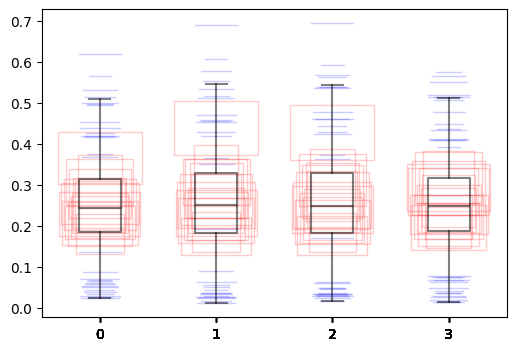

In [126]:
from src.utils import get_theta_samples_errors
from src.parameters import compute_real_theta_from_config

true_thetas = compute_real_theta_from_config(exp_config)
theta_name = "VAR1_A_hat"
plot_box_overlap(df_error, theta_name, true_theta=true_thetas[theta_name], alpha=0.2, margin_ratio=0.2)

<module 'src.config' from '/home/charl/repos/bayesian-prediction/src/config.py'>


In [1]:
from src.utils import load_inference_results, get_theta_samples_errors
from src.parameters import compute_real_theta_from_config, THETA_HAT_FUNC_DICT, TRUE_THETA_FUNC_DICT
from src.plotting import (
    plot_posterior_distributions,
    plot_posterior_boxplots,
    plot_posterior_eigvals_boxplots,
)
import matplotlib.pyplot as plt
import numpy as np
# auto reload
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib.patches import Patch

def plot_seeded_boxplots(base_exp_name: str, seeds: list[int], theta_name: str, remove_methods: list[str] = []):
    from matplotlib.cm import get_cmap

    cmap = get_cmap("tab10")
    color_map = {seed: cmap(i % 10) for i, seed in enumerate(seeds)}
    k = len(seeds)

    sample_groups = {}
    method_list = []

    for seed in seeds:
        exp_name = f"{base_exp_name}, seed={seed}"
        results, config, X_obs = load_inference_results(exp_name)
        theta_hat = THETA_HAT_FUNC_DICT[theta_name](X_obs)
        for method, samples in results[theta_name].items():
            if method not in remove_methods:
                if method not in sample_groups:
                    sample_groups[method] = []
                    method_list.append(method)
                sample_groups[method].append((samples, seed, theta_hat))

    method_spacing = 0.15
    width = 0.5 / k
    all_samples = []
    all_positions = []
    all_colors = []
    all_obs_lines = []

    pos = 0
    yticks = []
    yticklabels = []

    for method in method_list[::-1]:
        entries = sample_groups[method]
        for i, (samples, seed, theta_hat) in enumerate(entries):
            samples = samples[~np.isnan(samples)]
            all_samples.append(samples)
            all_positions.append(pos)
            all_colors.append(color_map[seed])
            all_obs_lines.append((theta_hat, pos, color_map[seed]))
            pos += 0.6/k
        pos += method_spacing  # space between method blocks
        # Pos for labels
        method_positions = all_positions[-len(entries):]  # last k positions for this method
        yticks.append(np.mean(method_positions))
        yticklabels.append(method)

    base_height = 4
    fig_height = base_height + 0.5 * len(method_list)
    fig, ax = plt.subplots(figsize=(8, fig_height))

    box = ax.boxplot(
        all_samples,
        vert=False,
        positions=all_positions,
        widths=width,
        patch_artist=True,
        showfliers=False,
        whis=1.5
    )

    for patch, color in zip(box['boxes'], all_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    for median in box['medians']:
        median.set_color('black')

    for x, y, color in all_obs_lines:
        ax.axvline(x=x, ymin=0, ymax=1, color=color, linestyle=":", linewidth=1)

    true_theta = compute_real_theta_from_config(config)[theta_name]
    ax.axvline(x=true_theta, color="black", linestyle="--", linewidth=1.5, label='True θ')

    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_xlabel("$\\theta$ posterior samples")
    ax.set_title(f"Posterior Boxplots $\\theta=$`{theta_name}` ({base_exp_name})", fontsize=12)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    legend_handles = [
        plt.Line2D([0], [0], color='black', linestyle="--", label="Real $\\theta$"),
        plt.Line2D([0], [0], color='black', linestyle=":", label="$\\hat{\\theta}_{obs}$"),
    ]
    legend_handles += [
        Patch(color=color_map[seed], label=f"seed={seed}", alpha=0.6)
        for seed in seeds
    ]
    ax.legend(handles=legend_handles, loc="best")

    plt.tight_layout()
    print(method_list)
    return fig, ax




/tmp/ipykernel_972/2324755776.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab10")


['PR\nNormal', 'PR\nStudent-T', 'LP\nUninf. prior', 'LP\nWrong Normal L']


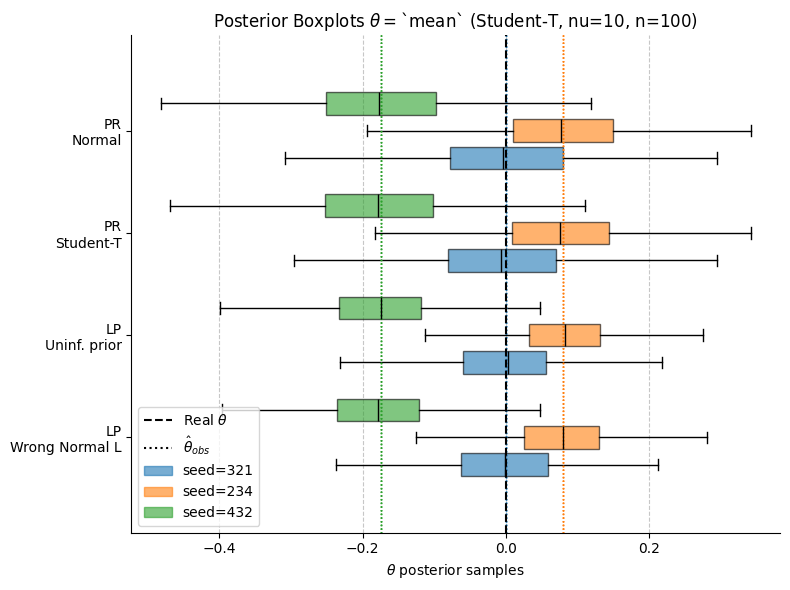

/tmp/ipykernel_972/2324755776.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab10")


['PR\nNormal', 'PR\nStudent-T', 'LP\nUninf. prior', 'LP\nWrong Normal L']


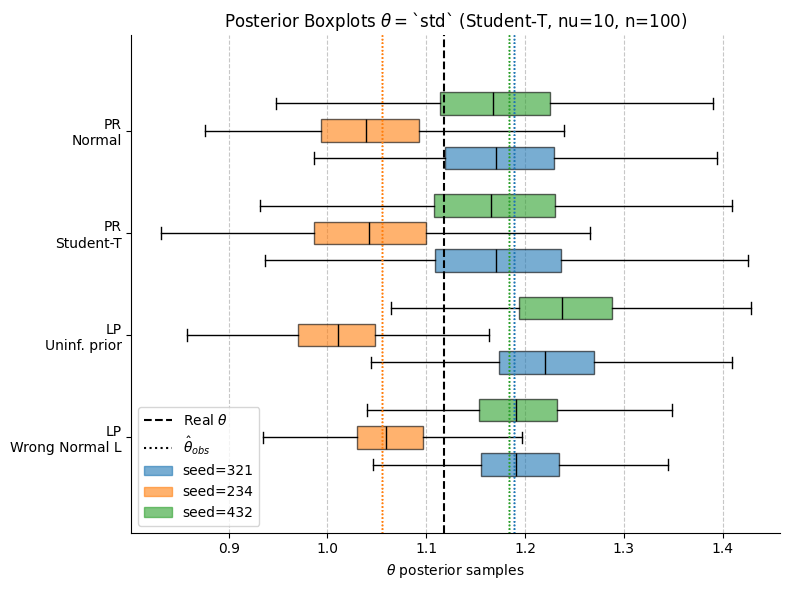

/tmp/ipykernel_972/2324755776.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab10")


['PR\nNormal', 'PR\nStudent-T', 'LP\nUninf. prior', 'LP\nWrong Normal L']


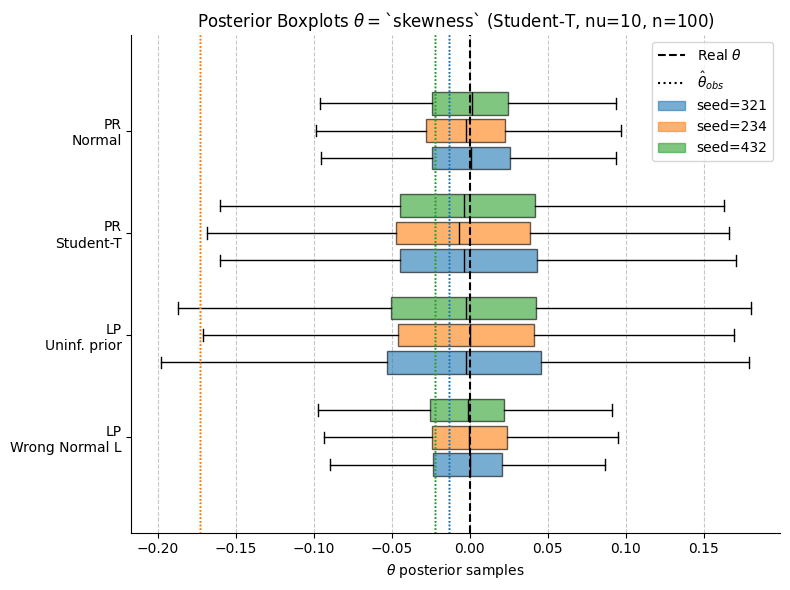

/tmp/ipykernel_972/2324755776.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab10")


['PR\nNormal', 'PR\nStudent-T', 'LP\nUninf. prior', 'LP\nWrong Normal L']


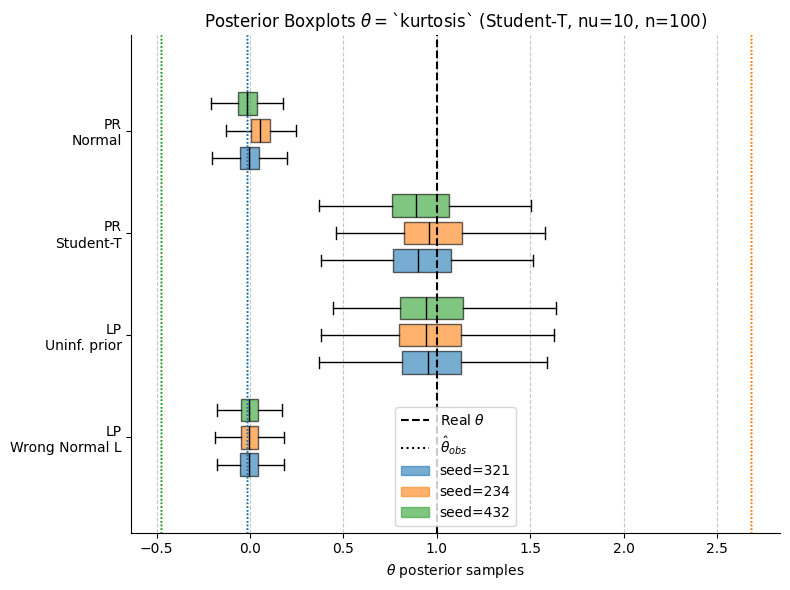

/tmp/ipykernel_972/2324755776.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab10")


['PR\nNormal', 'PR\nStudent-T', 'LP\nUninf. prior', 'LP\nWrong Normal L']


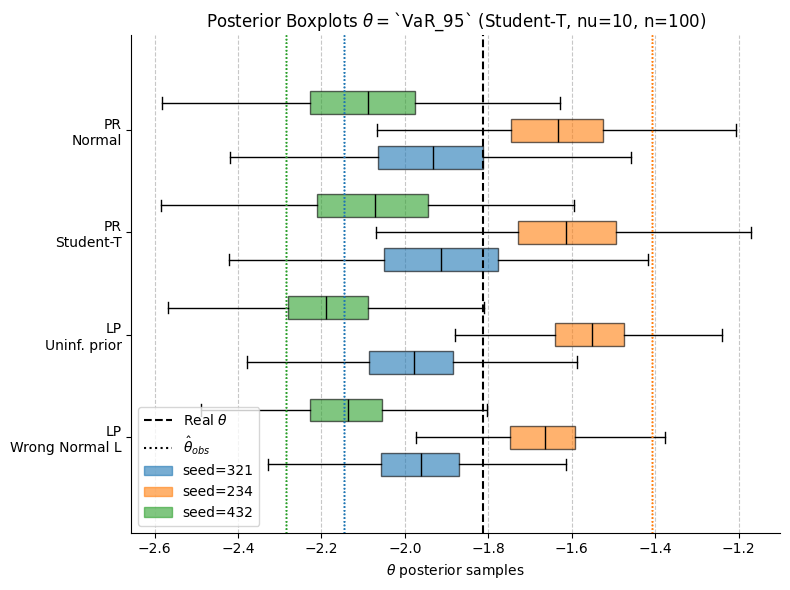

/tmp/ipykernel_972/2324755776.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab10")


['PR\nNormal', 'PR\nStudent-T', 'LP\nUninf. prior', 'LP\nWrong Normal L']


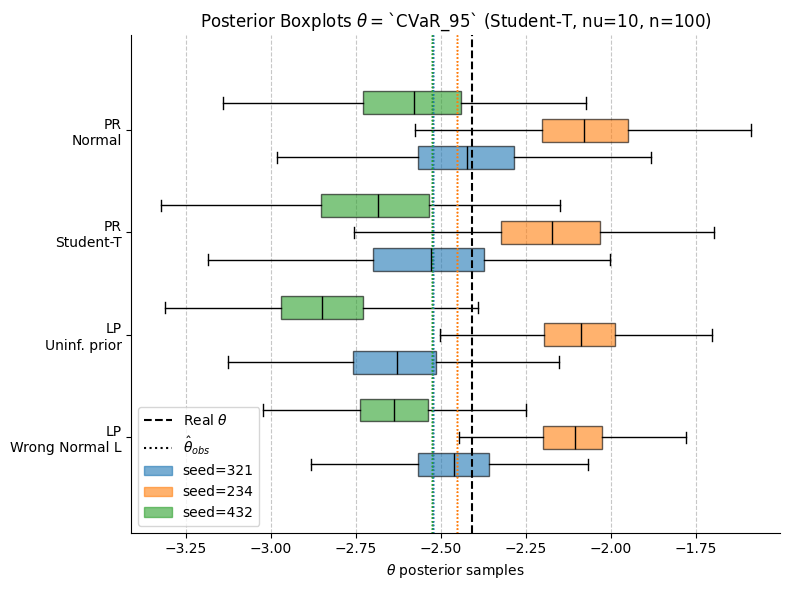

In [11]:
base_exp_name = "Student-T, nu=10, n=100"
remove_methods = [
    'PR\nEmpirical',
    # 'PR\nNormal',
    # 'LP\nUninf. prior',
    'LP\nInform. prior',
    'LP\nWrong Student-T L',
    # 'LP\nWrong Normal L',
]
theta_names = ["mean", "std", "skewness", "kurtosis", "VaR_95", "CVaR_95"]
seeds = [321, 234, 432]
for theta_name in theta_names:
    plot_seeded_boxplots(base_exp_name, seeds, theta_name, remove_methods=remove_methods)
    plt.savefig(
        f"plots/boxplots/{base_exp_name.replace(' ', '_').replace('.', '').replace(',', '').lower()}_{theta_name}.png",
        bbox_inches='tight'
    )
    plt.show()

### Echangeable 1D

In [ ]:

experiment_name = "Student-T, nu=10, n=100, seed=321"  # folder name in inference_results
theta_name = "VaR_95"  # name of the parameter to plot, e.g., "skewness", "kurtosis", "mean", "variance", etc.

# List methods to exclude from plot
remove_methods = [
    # "bayesian_incorrect_likelihood",
    # "resampling_empirical_t",
    
]
#########
experiment_results, experiment_config, X_obs = load_inference_results(experiment_name)

print(experiment_config)
print(experiment_results.keys())
theta_samples = experiment_results[theta_name]
for method in remove_methods:
    if method in theta_samples:
        del theta_samples[method]
true_theta = compute_real_theta_from_config(experiment_config)[theta_name]
theta_hat_obs = THETA_HAT_FUNC_DICT[theta_name](X_obs)

plot_posterior_distributions(
    theta_samples=experiment_results[theta_name],
    true_theta=true_theta,
    theta_hat_obs=theta_hat_obs,
    plot_type='both',
    bins=100,
    figsize=(10, 6),
    title=f"Posterior Distributions of $\\theta=${theta_name} ({experiment_name})",
    xlabel=f'{theta_name} estimates',
    ylabel='Density',
    show_legend=True,
    alpha=0.3,
    # x_range=(-1.5, 1.5),
)
# # changing legend names
# handles, labels = plt.gca().get_legend_handles_labels()
# print("Original labels:", labels)
# handles = [h for h, l in zip(handles, labels) if l not in remove_methods]
# labels = [NICE_LABEL_MAP.get(l, l) for l in labels]
# plt.legend(handles, labels, loc='upper right')
plt.tight_layout()
plt.title(f"Posterior Distributions of {theta_name} ({experiment_name})")
plt.xlabel(f'{theta_name} estimates')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()

plt.show()

fig, ax = plot_posterior_boxplots(
    theta_samples=experiment_results[theta_name],
    true_theta=true_theta,
    theta_hat_obs=theta_hat_obs,
    title=f"Posterior Boxplots $\\theta=${theta_name} ({experiment_name})",
    xlabel='$\\theta$',
    showfliers=False,
)

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:

experiment_name = "old/Student-T (nu=5, n=100)"  # folder name in inference_results
theta_name = "CVaR_95"  # name of the parameter to plot, e.g., "skewness", "kurtosis", "mean", "variance", etc.

# List methods to exclude from plot
remove_methods = [
    # "bayesian_incorrect_likelihood",
    # "resampling_empirical_t",
    
]
#########
experiment_results, experiment_config, X_obs = load_inference_results(experiment_name)
print(experiment_results.keys())
theta_samples = experiment_results[theta_name]
for method in remove_methods:
    if method in theta_samples:
        del theta_samples[method]
true_theta = compute_real_theta_from_config(experiment_config)[theta_name]
theta_hat_obs = THETA_HAT_FUNC_DICT[theta_name](X_obs)

plot_posterior_distributions(
    theta_samples=experiment_results[theta_name],
    true_theta=true_theta,
    theta_hat_obs=theta_hat_obs,
    plot_type='both',
    bins=100,
    figsize=(10, 6),
    title=f"Posterior Distributions of $\\theta=${theta_name} ({experiment_name})",
    xlabel=f'{theta_name} estimates',
    ylabel='Density',
    show_legend=True,
    alpha=0.3,
    # x_range=(-1.5, 1.5),
)
# # changing legend names
# handles, labels = plt.gca().get_legend_handles_labels()
# print("Original labels:", labels)
# handles = [h for h, l in zip(handles, labels) if l not in remove_methods]
# labels = [NICE_LABEL_MAP.get(l, l) for l in labels]
# plt.legend(handles, labels, loc='upper right')
plt.tight_layout()
plt.title(f"Posterior Distributions of {theta_name} ({experiment_name})")
plt.xlabel(f'{theta_name} estimates')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()

plt.show()

fig, ax = plot_posterior_boxplots(
    theta_samples=experiment_results[theta_name],
    true_theta=true_theta,
    theta_hat_obs=theta_hat_obs,
    title=f"Posterior Boxplots of {theta_name} ({experiment_name})",
    xlabel=f'{theta_name} estimates',
)
# # change yticks label by getting the current y-tick labels
# # get yticklabels
# yticklabels = ax.get_yticklabels()
# ax.set_yticklabels(
#     [NICE_LABEL_MAP.get(tick.get_text(), tick.get_text()) for tick in yticklabels],
#     fontsize=10
# )
# # change legend names
# handles, labels = plt.gca().get_legend_handles_labels()
# handles = [h for h, l in zip(handles, labels) if l not in remove_methods]
# labels = [NICE_LABEL_MAP.get(l, l) for l in labels]
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
from src.generating_data import generate_exchangeable_data

data_t = generate_exchangeable_data(dist_name="StudentT", dist_params={"nu": 5, "sigma": 1, "mu": 0}, n_samples=1000, random_seed=124)[0]
data_n = generate_exchangeable_data(dist_name="Normal", dist_params={"sigma": 1, "mu": 0}, n_samples=1000, random_seed=124)[0]

print(THETA_HAT_FUNC_DICT[theta_name](data_t))
print(THETA_HAT_FUNC_DICT[theta_name](data_n))

### VAR(1) simulations


In [ ]:

# Setting experiment
experiment_name = "VAR1 (n=1000)"
theta_name = "VAR1_A_hat"
remove_methods = [
    # "bayesian_incorrect_likelihood"
    # "bayesian_bvar_analytical",
    "bayesian_bvar_uninformative",
    # "bayesian_bvar_minnesota_wrong",
    # "bayesian_bvar_minnesota_chat_gpt",
    "bayesian_bvar_minnesota"
]

# Loading & preparing results
experiment_results, experiment_config, X_obs = load_inference_results(experiment_name)
theta_samples = experiment_results[theta_name]
for method in remove_methods:
    if method in theta_samples:
        del theta_samples[method]
true_theta = np.array(experiment_config['A'])
theta_hat_obs = THETA_HAT_FUNC_DICT[theta_name](X_obs)

theta_samples = {
    method: np.array(samples) for method, samples in theta_samples.items() if method not in remove_methods
}

# PLotting boxplots of eigenvalues
fig, axes = plot_posterior_eigvals_boxplots(
    theta_samples=theta_samples,
    true_theta=true_theta,
    theta_hat_obs=theta_hat_obs,
)
# Make plot nicers
axes[0].set_xlabel("$\\lambda_1$")
axes[1].set_xlabel("$\\lambda_2$")
# change yticks label by getting the current y-tick labels

axes[0].set_yticklabels(
    ["PR", "BVAR\n(Jeffreys)", "BVAR\n(Minnesota, uninf.)", "BVAR\n(Minnesota, ChatGPT)"],
    fontsize=10,
)
fig.suptitle(f"Boxplots of the posterior sample eigenvalues of $A$ ({experiment_name})")
fig.tight_layout()
plt.show()



In [ ]:

# Plotting normalized errors
theta_error_samples = get_theta_samples_errors(theta_samples, true_theta)
plot_posterior_distributions(
    theta_samples=theta_error_samples,
    # true_theta=0.0,
    theta_hat_obs=np.linalg.norm(theta_hat_obs - true_theta, ord='fro')/np.linalg.norm(true_theta, ord='fro'),
    plot_type='density',
    bins=100,
    figsize=(10, 6),
    title=f"Posterior Distributions of $A$ normalized errors ({experiment_name})",
    xlabel='Errors',
    ylabel='Density',
    show_legend=True,
    alpha=0.3,
)
fig, ax = plt.gcf(), plt.gca()
# changing legend names
handles, labels = plt.gca().get_legend_handles_labels()
handles = [h for h, l in zip(handles, labels) if l not in remove_methods]
labels = ["PR", "BVAR\n(Jeffreys)", "BVAR\n(Minnesota, uninf.)", "BVAR\n(Minnesota, ChatGPT)"]
plt.legend(handles, labels, loc='upper right')
plt.tight_layout()
plt.show()

# boxplot
fig, ax = plot_posterior_boxplots(
    theta_samples=theta_error_samples,
    # true_theta=0.0,
    theta_hat_obs=np.linalg.norm(theta_hat_obs - true_theta, ord='fro')/np.linalg.norm(true_theta, ord='fro'),
    title="",
    xlabel='Normalized Error',
)
# change yticks label by getting the current y-tick labels
ax.set_yticklabels(
    ["PR", "BVAR\n(Jeffreys)", "BVAR\n(Minnesota, uninf.)", "BVAR\n(Minnesota, ChatGPT)"],
    fontsize=11
)
fig.tight_layout()
plt.title(f"Posterior Boxplots of $A$ normalized errors ({experiment_name})")
plt.legend()
plt.show()


In [ ]:
from src.chooseN_pipeline import choose_N_1D

experiment_name = "Normal (n=1000)"
experiment_results, experiment_config, X_obs = load_inference_results(experiment_name)

N_step = 100
N_min = 100
N_max = 20000
avg_errors_dict = choose_N_1D(
    experiment_config=experiment_config,
    N_max=N_max,
    N_min=N_min,
    N_step=N_step,
    iterations=20,
)

In [ ]:
# PLot for all keys
for key, avg_errors in avg_errors_dict.items():
    plt.plot(avg_errors, label=key)
    plt.xlabel(f'N/{N_step} - {N_min}')
    plt.ylabel('Normalized Avg. Abs. Error')
    #ylog scale
    plt.yscale('log')
    plt.title(f'Normalized Avg. Abs. Error of {key} ({experiment_name})')
    plt.show()

In [ ]:
from src.chooseN_pipeline import choose_N_1D

experiment_name = "Student-T, nu=30, n=1000, seed=321"
experiment_results, experiment_config, X_obs = load_inference_results(experiment_name)

N_step = 100
N_min = 100
N_max = 20000
avg_errors_dict = choose_N_1D(
    experiment_config=experiment_config,
    N_max=N_max,
    N_min=N_min,
    N_step=N_step,
    iterations=20,
)

In [ ]:
# PLot for all keys
for key, avg_errors in avg_errors_dict.items():
    plt.plot(avg_errors, label=key)
    plt.xlabel(f'N/{N_step} - {N_min}')
    plt.ylabel('Normalized Avg. Abs. Error')
    #ylog scale
    plt.yscale('log')
    plt.title(f'Normalized Avg. Abs. Error of {key} ({experiment_name})')
    plt.show()

In [ ]:
from src.chooseN_pipeline import choose_N

experiment_name = "VAR1 (n=100)"
experiment_results, experiment_config, X_obs = load_inference_results(experiment_name)

N_step = 100
N_min = 100
N_max = 10000
avg_errors_dict = choose_N(
    experiment_config=experiment_config,
    VAR1=True,
    N_max=N_max,
    N_min=N_min,
    N_step=N_step,
    iterations=10,
)

In [ ]:
# PLot for all keys
KEY_MAP = {"VAR1_A_hat": "$\\hat{A}$", "VAR1_sigma_eps_hat": "$\\hat{\\Sigma}$"}
for key, avg_errors in avg_errors_dict.items():
    plt.plot(avg_errors, label=key)
    plt.xlabel(f'N/{N_step} - {N_min}')
    plt.ylabel('Normalized Error')
    #ylog scale
    plt.yscale('log')
    plt.title(f'Normalized Frobenius Error of {KEY_MAP.get(key, key)}')
    plt.show()

In [ ]:
# PLot for all keys
for key, avg_errors in avg_errors_dict.items():
    plt.plot(avg_errors, label=key)
    plt.xlabel(f'N/{N_step} - {N_min}')
    plt.ylabel('Normalized Avg. Abs. Error')
    #ylog scale
    plt.yscale('log')
    plt.title(f'Normalized Avg. Abs. Error of {key} ({experiment_name})')
    plt.show()